# **PCA and Clastering**
In this notebook, I will apply Dimensionality Reduction and Clustering on Retail Dataset

### Objective
Main objective is to investigate customer purchasing patterns, perform market segmentation and identify anomalies. By identifying distinct groups of customers, a retail business can tailor its marketing strategies, optimize inventory, and improve customer retention.

## Let's download dataset

In [1]:
! wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

--2026-01-15 12:46:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [             <=>    ]  22.62M  8.92MB/s    in 2.5s    

2026-01-15 12:47:00 (8.92 MB/s) - ‘Online Retail.xlsx’ saved [23715344]



## Let's explore the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest


df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [6]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Data Cleaning

In [7]:
df.drop('Description', axis=1, inplace=True)

In [8]:
df_cleaned = df.dropna(subset=['CustomerID'])
df_cleaned.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [9]:
print(len(df_cleaned)) # Data left after null rows

406829


In [10]:
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
print(len(df_cleaned)) # Data left after negative quantity

397924


In [11]:
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]
print(len(df_cleaned)) # Data left after negative price

397884


## Feature Engineering

In [12]:
df_cleaned['TotalSum'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df_cleaned.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalSum': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


## Data Transformation and Scaling

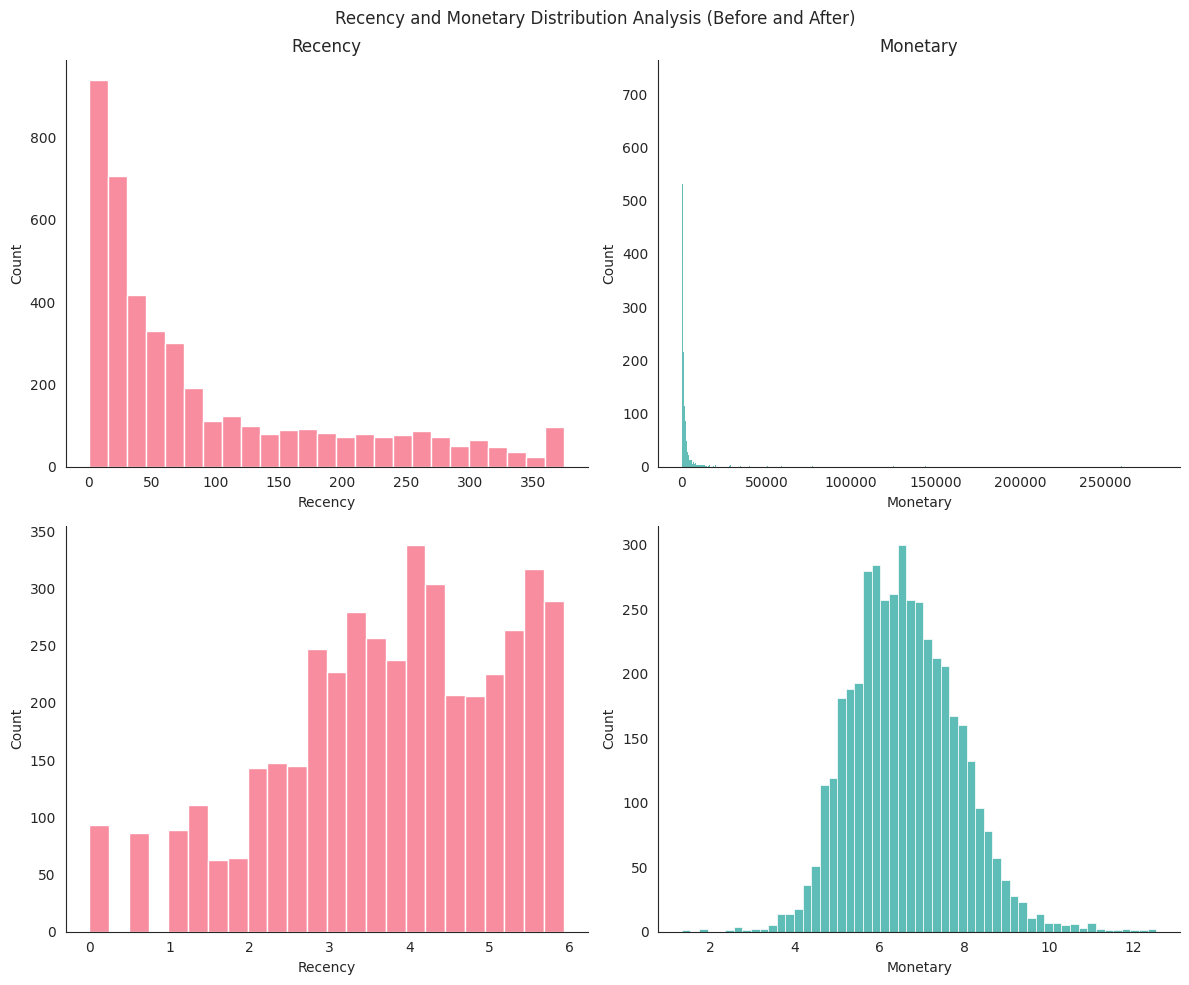

In [13]:
rfm_log = np.log(rfm)
colors = sns.color_palette("husl", 2)

sns.set_style("white")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(rfm['Recency'], kde=False, ax=axes[0, 0], color=colors[0], alpha=0.8)
sns.histplot(rfm['Monetary'], kde=False, ax=axes[0, 1], color=colors[1], alpha=0.8)

sns.histplot(rfm_log['Recency'], kde=False, ax=axes[1, 0], color=colors[0], alpha=0.8)
sns.histplot(rfm_log['Monetary'], kde=False, ax=axes[1, 1], color=colors[1], alpha=0.8)

axes[0, 0].set_title('Recency')
axes[0, 1].set_title('Monetary')

plt.suptitle('Recency and Monetary Distribution Analysis (Before and After)')
sns.despine()
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print(rfm_scaled.describe().round(2))

       Recency  Frequency  Monetary
count  4338.00    4338.00   4338.00
mean     -0.00      -0.00     -0.00
std       1.00       1.00      1.00
min      -2.63      -1.05     -4.18
25%      -0.61      -1.05     -0.68
50%       0.11      -0.28     -0.06
75%       0.83       0.74      0.65
max       1.51       4.88      4.72


## Dimensionality Reduction (PCA)

In [15]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(rfm_scaled)

pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=rfm.index)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance captured: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

Explained variance ratio: [0.75210413 0.18739977]
Total variance captured: 93.95%


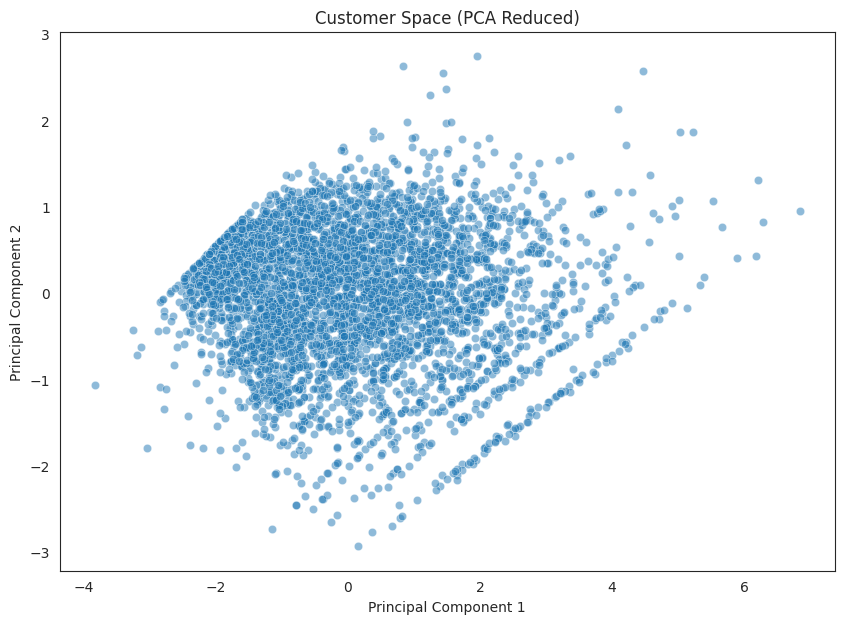

In [16]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.5)
plt.title('Customer Space (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [17]:
components = pd.DataFrame(pca.components_, columns=rfm.columns, index=['PC1', 'PC2'])
print(components)

      Recency  Frequency  Monetary
PC1 -0.512234   0.618358  0.596028
PC2  0.848527   0.257119  0.462484


## Clustering

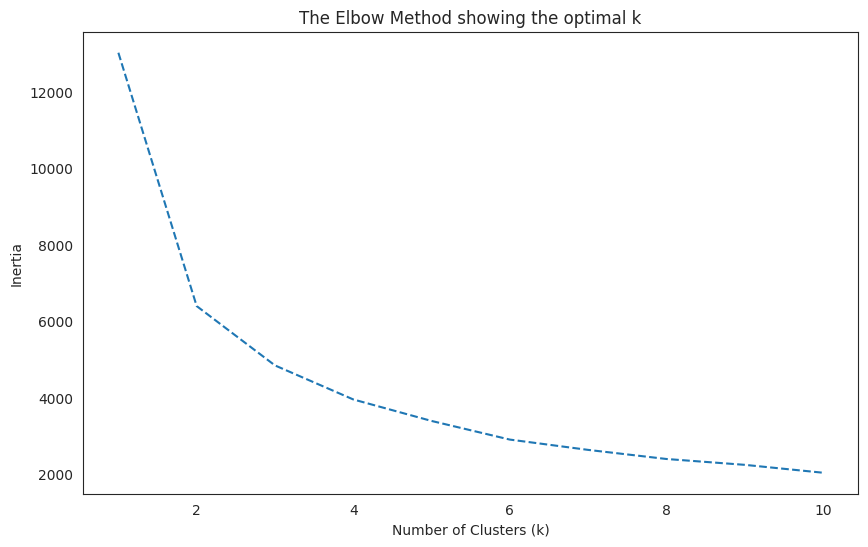

In [18]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, '--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2, the silhouette score is 0.4320
For n_clusters = 3, the silhouette score is 0.3370
For n_clusters = 4, the silhouette score is 0.3302
For n_clusters = 5, the silhouette score is 0.3091
For n_clusters = 6, the silhouette score is 0.3099
For n_clusters = 7, the silhouette score is 0.2926
For n_clusters = 8, the silhouette score is 0.2984
For n_clusters = 9, the silhouette score is 0.2882
For n_clusters = 10, the silhouette score is 0.2869


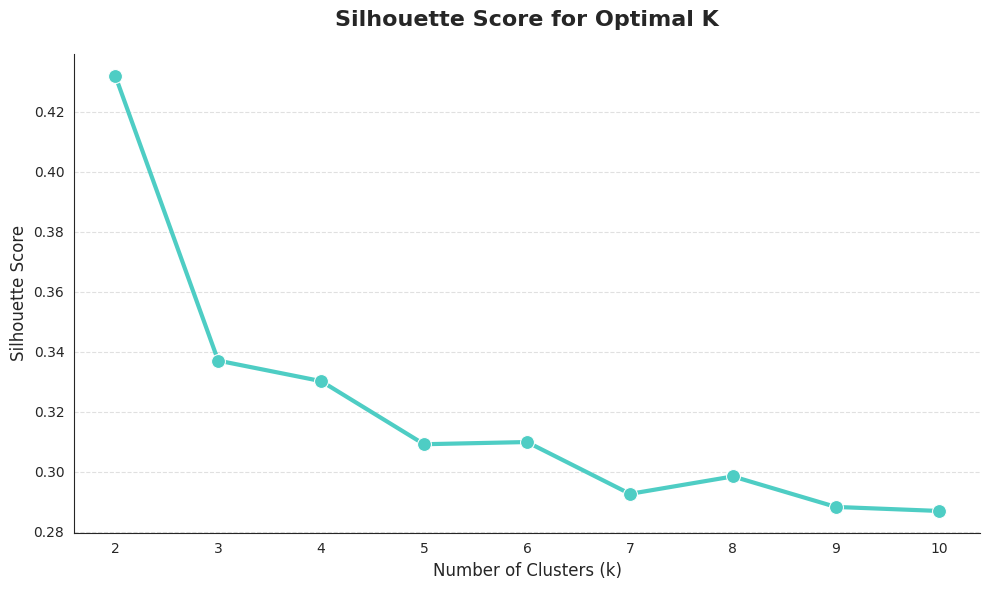

In [19]:
silhouette_avg = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_avg.append(score)
    print(f"For n_clusters = {k}, the silhouette score is {score:.4f}")

plt.figure(figsize=(10, 6))
sns.set_style("white")

sns.lineplot(x=k_range, y=silhouette_avg, marker='o', color='#4ECDC4', linewidth=3, markersize=10)

plt.title('Silhouette Score for Optimal K', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

In [20]:
number_of_clusters = 4

kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_profile)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          21.6       1.9    467.6   795
1          10.3      13.0   7677.6   756
2         189.5       1.3    343.9  1508
3          70.9       4.1   1733.2  1279


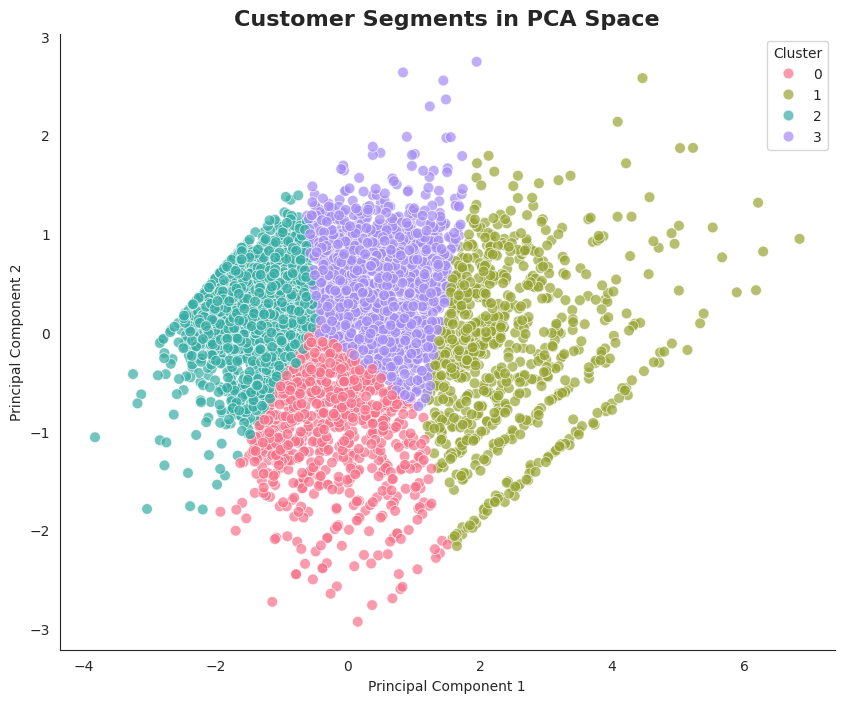

In [21]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster'].values

plt.figure(figsize=(10, 8))
sns.set_style("white")

sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=pca_df,
    palette=sns.color_palette("husl", number_of_clusters),
    s=60, alpha=0.7, edgecolor='w'
)

plt.title('Customer Segments in PCA Space', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
sns.despine()
plt.show()

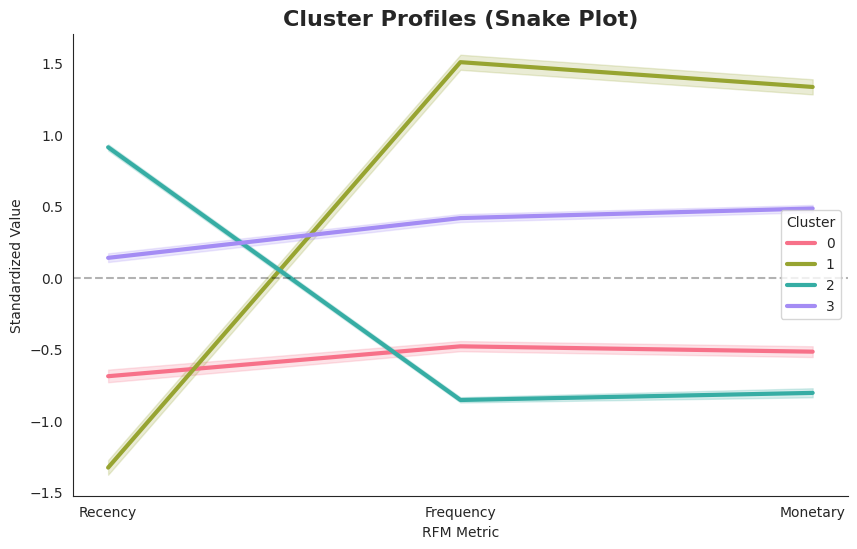

In [22]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df['Cluster'] = rfm['Cluster'].values

rfm_melted = pd.melt(
    rfm_scaled_df,
    id_vars=['Cluster'],
    value_vars=['Recency', 'Frequency', 'Monetary'],
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Metric', y='Value',
    hue='Cluster',
    data=rfm_melted,
    palette=sns.color_palette("husl", number_of_clusters),
    linewidth=3
)

plt.title('Cluster Profiles (Snake Plot)', fontsize=16, fontweight='bold')
plt.xlabel('RFM Metric')
plt.ylabel('Standardized Value')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
sns.despine()
plt.show()

### **Segmentation Analysis Results**

**Cluster 1: The Champions (High Value)**  
*   **Profile:** Lowest recency (10.3 days), highest frequency (13.0 orders), and highest spend ($7,677.6).  
*   **Strategy:** Your most valuable group. Focus on **retention** and exclusive loyalty rewards to maintain their high lifetime value.

**Cluster 3: Loyal Regulars (Mid-Tier)**  
*   **Profile:** Active shoppers with moderate frequency (4.1 orders) and solid spending ($1,733.2).  
*   **Strategy:** Use **cross-selling** and personalized product recommendations to increase their purchase frequency and average order value.

**Cluster 0: New/Occasional Shoppers**  
*   **Profile:** Shopped recently (21.6 days) but with low frequency (1.9 orders) and low spend ($467.6).  
*   **Strategy:** Focus on **onboarding**. Send welcome series emails or "next purchase" incentives to convert them into multi-buy regulars.

**Cluster 2: Hibernating / At Risk**  
*   **Profile:** Highest recency (189.5 days), lowest frequency (1.3 orders), and lowest spend ($343.9).  
*   **Strategy:** These customers have likely churned. Use automated **re-engagement** campaigns or aggressive "win-back" discounts to trigger a return visit.

### **Key Takeaway**
The model effectively separated the **high-frequency "Whales" (Cluster 1)** from the **one-time shoppers (Cluster 2)**. Marketing efforts should be prioritized toward **Cluster 1** for revenue protection and **Cluster 0** for immediate growth potential.

## Anomaly Detection

In [23]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)

rfm['Anomaly'] = iso_forest.fit_predict(rfm_scaled)

print(rfm['Anomaly'].value_counts())

Anomaly
 1    4294
-1      44
Name: count, dtype: int64


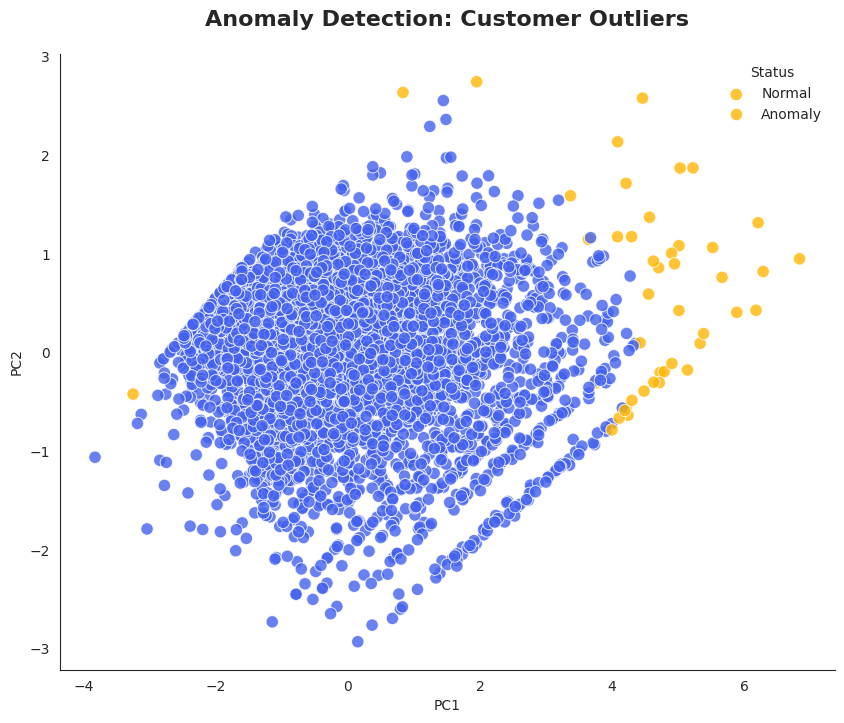

In [24]:
pca_df['Anomaly'] = rfm['Anomaly'].values

new_palette = {1: "#4361EE", -1: "#FFB703"}

plt.figure(figsize=(10, 8))
sns.set_style("white")

sns.scatterplot(
    x='PC1', y='PC2',
    hue='Anomaly',
    data=pca_df,
    palette=new_palette,
    s=80,
    alpha=0.8,
    edgecolor='white'
)

plt.title('Anomaly Detection: Customer Outliers', fontsize=16, fontweight='bold', pad=20)
plt.legend(title="Status", labels=['Normal', 'Anomaly'], frameon=False)
sns.despine()

plt.show()

In [25]:
anomalies = rfm[rfm['Anomaly'] == -1]

print("Сравнение аномалий и нормальных клиентов:")
print(rfm.groupby('Anomaly')[['Recency', 'Frequency', 'Monetary']].mean())

Сравнение аномалий и нормальных клиентов:
           Recency  Frequency      Monetary
Anomaly                                    
-1       29.068182  50.363636  58677.457500
 1       93.186772   3.799721   1474.056771


### **Anomaly Detection Analysis Results**

**Anomalies (-1): The "Whale" Accounts / Bulk Buyers**  
*   **Profile:** High activity (33.8 days recency), extreme purchase frequency (50.3 orders), and massive average spend ($59,239.5).  
*   **Business Context:** These are not "errors" but rather **High-Value Outliers**. They likely represent B2B clients, wholesalers, or institutional buyers whose behavior is mathematically different from individual retail consumers.  

**Normal (1): The Retail Consumer Base**  
*   **Profile:** Lower engagement (93.1 days recency), standard frequency (3.8 orders), and modest spend ($1,468.3).  
*   **Business Context:** This group represents the standard customer journey. Their behavior follows a predictable pattern suitable for standard clustering algorithms.

### **Key Takeaway**
The **Isolation Forest** identified a small segment of customers who spend **~40x more** and shop **~13x more often** than the average customer. Removing or isolating these "Whales" is crucial during clustering to prevent them from skewing the results and ensuring that the segments developed for the "Normal" group remain actionable and balanced.